In [1]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
import torchmetrics
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset


from xgboost import XGBClassifier
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, classification_report, ConfusionMatrixDisplay
%matplotlib inline

In [2]:
validation_split = 0.3
shuffle_dataset  = True
batch_size = 64
max_epochs = 100
input_size = 33

In [3]:
def load_transaction(only_fraud=False):
    df = pd.read_csv("transaction_dataset.csv")

    #Rename columns for easier access
    df.columns = df.columns.str.strip().str.replace(' ','_').str.lower()

    #Remove weird stuff 
    df.drop(columns=['unnamed:_0'], inplace=True)

    #Remove duplicate accounts
    df.drop_duplicates(subset=['address'], inplace=True)

    #Remove accounts 
    df.drop(columns=['address'], inplace=True)

    #Remove index
    df.drop(columns=['index'], inplace=True)

    #Remove token names 
    df.drop(columns=['erc20_most_sent_token_type','erc20_most_rec_token_type'], inplace = True)

    #Remove var=0 columns
    df.drop(df.var(numeric_only=True)[df.var(numeric_only=True) == 0].index, axis = 1, inplace = True)

    #Remove small distribution columns
    small_distr_col = []
    for col in df.columns[3:] :
        if df[col].nunique() < 10:
            small_distr_col.append(col)
    df.drop(columns=small_distr_col,inplace = True)
    
    # Remove negative values 
    df[df<0] = None 
    df.dropna(inplace=True)
    
    if(only_fraud):
        df.drop(df[df['flag'] == 0].index, inplace = True)
    
    return df


def train_test_split_indices(length, validation_split, shuffle_dataset = True, random_seed = 42):
    # Creating data indices for training and validation splits.
    indices = np.arange(length)
    validation_size = int(validation_split * length)
    if shuffle_dataset:
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_indices, val_indices = indices[validation_size:], indices[:validation_size]
    return train_indices, val_indices

class MyDataset(Dataset):
    def __init__(self, df, indices, augment = False, 
                 cols_median = None, cols_means = None, cols_std = None):
        super().__init__()
        self.augment = augment
        
        df = df.iloc[indices].copy()
        
        if(self.augment):
            oversample = SMOTE()
            df,y = oversample.fit_resample(df.iloc[:,1:],df.values[:,0])
        else: 
            y,df  = df.values[:, 0],df.iloc[:, 1:]
        
        if any(param is None for param in [cols_median, cols_means, cols_std]):
            self.cols_median = df.median(numeric_only=True)
            self.cols_means  = df.mean  (numeric_only=True)
            self.cols_std    = df.std   (numeric_only=True)
        else:
            self.cols_median = cols_median
            self.cols_means  = cols_means
            self.cols_std    = cols_std
            
        df.fillna(self.cols_median, inplace = True)
        df = (df - self.cols_means) / self.cols_std
        
        self.y = y
        self.X = df.values                                    
        
    def get_cols_stats(self):
        return self.cols_median, self.cols_means, self.cols_std
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]
        
        if self.augment:
            pass
        
        return x, y
class MyDataModule(pl.LightningDataModule):
    def __init__(self, df, batch_size, train_indices, val_indices,augment):
        super().__init__()
        self.df = df
        self.batch_size = batch_size
        self.train_indices = train_indices
        self.val_indices = val_indices
        self.augment = augment
    def get_stats(self):
        return self.train_set.get_cols_stats()
    
    def setup(self, stage = None):
        self.train_set = MyDataset(self.df, self.train_indices, augment = self.augment)
        
        train_cols_median, train_cols_means, train_cols_std = self.train_set.get_cols_stats()
        
        self.val_set = MyDataset(self.df, self.val_indices,
                                 augment = False,
                                 cols_median = train_cols_median,
                                 cols_means  = train_cols_means,
                                 cols_std    = train_cols_std)
          
    def train_dataloader(self):
        return DataLoader(self.train_set,
                          batch_size = self.batch_size,
                          shuffle = True,
                          num_workers = 8,
                          pin_memory = True)
    def val_dataloader(self):
        return DataLoader(self.val_set,
                          batch_size = self.batch_size,
                          shuffle = False,
                          num_workers = 8,
                          pin_memory = True)


In [4]:
def train(model,only_fraud=False,augment=False,validation_split=validation_split,
          shuffle_dataset=False,batch_size=batch_size,
         max_epochs=max_epochs,input_size=input_size):

    df = load_transaction(only_fraud=only_fraud)


    train_indices, val_indices = train_test_split_indices(length = len(df),
                                                      validation_split = validation_split)        

    data = MyDataModule(df,
                        train_indices = train_indices,
                        val_indices   = val_indices,
                        batch_size    = batch_size,
                        augment       = augment)
    early_stopping = EarlyStopping('val_loss',patience=7)

    trainer = pl.Trainer(log_every_n_steps       = 10,
                         accelerator             = 'cpu',
                         check_val_every_n_epoch = 1,
                         enable_checkpointing    = False,
                         max_epochs              = max_epochs,
                         precision               = 64,
                         callbacks               = [],
                         num_sanity_val_steps    = 0,
                         fast_dev_run            = False)

    trainer.fit(model, data)

    return model

In [5]:
#Training and using the classifier 
df = load_transaction()

train_indices, val_indices = train_test_split_indices(length = len(df),
                                                  validation_split = validation_split)  
data = MyDataModule(df,
                        train_indices = train_indices,
                        val_indices   = val_indices,
                        batch_size    = 1,
                        augment       = False)
data.setup()

median, mean, std = data.get_stats()

test_data_loader = data.val_dataloader()
y_te = test_data_loader.dataset[:][1]
x_te = test_data_loader.dataset[:][0]

train_data_loader = data.train_dataloader()
y_tr = train_data_loader.dataset[:][1]
x_tr = train_data_loader.dataset[:][0]

xgb_c = XGBClassifier(random_state=42,objective='binary:logistic',use_label_encoder=False,eval_metric='auc')
xgb_c.fit(x_tr, y_tr.astype(int))


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [6]:
class Generator(pl.LightningModule):
    def __init__(self,classifier,input_size=33):
        super().__init__()
        self.classifier = classifier
        self.layers = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, input_size),
            nn.Tanh(),
        )
        
        
    def forward(self, x):
        return self.layers(x.view(x.size(0), -1))

    def training_step(self, batch, batch_idx):
        x, _ = batch
        #Create some kind of camouflage to hack the classifier
        camouflage = self(x)
        generated = x + camouflage
        r_loss = F.mse_loss(torch.zeros_like(camouflage), camouflage)
        
        #We want the predictions to all be zero (i.e, non fraud)
        preds = torch.tensor(self.classifier.predict(generated.detach())).double()
        preds.requires_grad_()
        c_loss = preds.mean()
        
        
        self.log('r_loss', r_loss, prog_bar = True, on_step = False, on_epoch = True)
        self.log('c_loss', c_loss, prog_bar = True, on_step = False, on_epoch = True)
        
        return (c_loss + 100*r_loss)/100
    
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.00001)

In [7]:
class GeneratorBIG(pl.LightningModule):
    def __init__(self,classifier,input_size=33):
        super().__init__()
        self.classifier = classifier
        self.layers = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, input_size),
            nn.Tanh(),
        )
        
        
    def forward(self, x):
        return self.layers(x.view(x.size(0), -1))

    def training_step(self, batch, batch_idx):
        x, _ = batch
        #Create some kind of camouflage to hack the classifier
        camouflage = self(x)
        generated = x + camouflage
        r_loss = F.mse_loss(torch.zeros_like(camouflage), camouflage)
        
        #We want the predictions to all be zero (i.e, non fraud)
        preds = torch.tensor(self.classifier.predict(generated.detach())).double()
        preds.requires_grad_()
        c_loss = preds.mean()
        
        
        self.log('r_loss', r_loss, prog_bar = True, on_step = False, on_epoch = True)
        self.log('c_loss', c_loss, prog_bar = True, on_step = False, on_epoch = True)
        
        return (c_loss + 100*r_loss)/100
    
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

In [8]:
class GeneratorHUGE(pl.LightningModule):
    def __init__(self,classifier,input_size=33):
        super().__init__()
        self.classifier = classifier
        self.layers = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, input_size),
            nn.Tanh(),
        )
        
        
    def forward(self, x):
        return self.layers(x.view(x.size(0), -1))

    def training_step(self, batch, batch_idx):
        x, _ = batch
        #Create some kind of camouflage to hack the classifier
        camouflage = self(x)
        generated = x + camouflage
        r_loss = F.mse_loss(torch.zeros_like(camouflage), camouflage)
        
        #We want the predictions to all be zero (i.e, non fraud)
        preds = torch.tensor(self.classifier.predict(generated.detach())).double()
        preds.requires_grad_()
        c_loss = preds.mean()
        
        
        self.log('r_loss', r_loss, prog_bar = True, on_step = False, on_epoch = True)
        self.log('c_loss', c_loss, prog_bar = True, on_step = False, on_epoch = True)
        
        return (c_loss + 100*r_loss)/100
    
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

In [9]:
genBIG = train(GeneratorBIG(xgb_c),only_fraud=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/santangelx/opt/anaconda3/envs/ml2/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:105: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 343 K 
--------------------------------------
343 K     Trainable params
0         Non-trainable params
343 K     Total params
2.749     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [10]:
genHUGE = train(GeneratorHUGE(xgb_c),only_fraud=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 2.4 M 
--------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
19.546    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [14]:
models = [genBIG,genHUGE]
good_camo = []
i=0
for model in models:
    i+=1
    total = 0
    detected_fraud = 0 
    beat_xgb = 0 
    for a,b in test_data_loader:
        if(b==1):
            total+=1
            camo = model(a).detach()
            adv = a + camo 
            if(xgb_c.predict(a)==1):
                if(xgb_c.predict(adv)==0):
                    if(i==1):good_camo.append(camo)
                    beat_xgb+=1
                detected_fraud+=1
    print("Model "+str(i)+" changed XGBOOST output "+str(beat_xgb)+" times on "+str(detected_fraud)+" detected fraud accounts ")
camo_mean = 0
for camo in good_camo:
    camo_mean+=camo.numpy()/len(good_camo)
camo_mean = camo_mean[0]

print(camo_mean@camo_mean.T)
camo_mean=(camo_mean+mean - mean )
print(camo_mean)

Model 1 changed XGBOOST output 160 times on 358 detected fraud accounts 
Model 2 changed XGBOOST output 174 times on 358 detected fraud accounts 
0.0004686124446487608
avg_min_between_sent_tnx                               -0.004395
avg_min_between_received_tnx                           -0.005533
time_diff_between_first_and_last_(mins)                 0.004872
sent_tnx                                                0.001452
received_tnx                                           -0.006153
number_of_created_contracts                             0.002115
unique_received_from_addresses                         -0.001619
unique_sent_to_addresses                                0.000455
min_value_received                                     -0.001334
max_value_received                                      0.004335
avg_val_received                                        0.004924
min_val_sent                                            0.003819
max_val_sent                                        

In [15]:
class Generator(nn.Module):
    def __init__(self, latent_dim, out_dim):
        super().__init__()
        self.out_dim = out_dim

        self.layers = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, out_dim),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.layers(x.view(x.size(0), -1))
        return x
class Discriminator(nn.Module):
    def __init__(self, input_size):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.layers(x.view(x.size(0), -1)).flatten()

        return x
class GAN(pl.LightningModule):
    def __init__(
        self,
        lr: float  = 0.0001,
        latent_dim = 50,
        input_size = 33
    ):
        super().__init__()
        self.input_size = input_size
        self.latent_dim = latent_dim
        self.lr         = lr

        self.generator = Generator(latent_dim,input_size)
        self.discriminator = Discriminator(input_size)


    def forward(self, z):
        return self.generator(z)

    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)

    def training_step(self, batch, batch_idx, optimizer_idx):
        addrs, _ = batch

        # sample noise
        z = torch.randn(addrs.shape[0],self.latent_dim)
        z = z.type_as(addrs)

        # train generator
        if optimizer_idx == 0:

            # ground truth result (ie: all fake)
            # put on GPU because we created this tensor inside training_loop
            valid = torch.ones(addrs.size(0), 1)
            valid = valid.type_as(addrs)

            # adversarial loss is binary cross-entropy
            g_loss = self.adversarial_loss(self.discriminator(self(z)).view(addrs.size(0), 1), valid)
            self.log("g_loss", g_loss, prog_bar=True, on_step = False, on_epoch = True)
            return g_loss

        # train discriminator
        if optimizer_idx == 1:
            # Measure discriminator's ability to classify real from generated samples

            # how well can it label as real?
            valid = torch.ones(addrs.size(0), 1)
            valid = valid.type_as(addrs)

            real_loss = self.adversarial_loss(self.discriminator(addrs).view(addrs.size(0), 1), valid)

            # how well can it label as fake?
            fake = torch.zeros(addrs.size(0), 1)
            fake = fake.type_as(addrs)

            fake_loss = self.adversarial_loss(self.discriminator(self(z).detach()).view(addrs.size(0), 1), fake)

            # discriminator loss is the average of these
            d_loss = (real_loss + fake_loss) / 2
            self.log("d_loss", d_loss, prog_bar=True, on_step = False, on_epoch = True)
            return d_loss

    def configure_optimizers(self):
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=self.lr)
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=self.lr)
        
        return [opt_g, opt_d], []
    
gan = train(GAN())
gan.discriminator.eval()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 16.9 K
1 | discriminator | Discriminator | 31.2 K
------------------------------------------------
48.2 K    Trainable params
0         Non-trainable params
48.2 K    Total params
0.385     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Discriminator(
  (layers): Sequential(
    (0): Linear(in_features=33, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=64, out_features=32, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=32, out_features=1, bias=True)
    (13): Sigmoid()
  )
)

In [16]:
class GeneratorGAN(pl.LightningModule):
    def __init__(self,classifier,discriminator,input_size=33):
        super().__init__()
        self.classifier = classifier
        self.discriminator = discriminator
        for params in self.discriminator.parameters():
            params.requires_grad = False 
            
        self.layers = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, input_size),
            nn.Tanh(),
        )
        
        
    def forward(self, x):
        return self.layers(x.view(x.size(0), -1))

    def training_step(self, batch, batch_idx):
        x, _ = batch
        #Create some kind of camouflage to hack the classifier
        camouflage = self(x)
        generated = x + camouflage
        r_loss = F.mse_loss(torch.zeros_like(camouflage), camouflage)
        
        #We want our generated account to ressemble other accounts 
        valid = torch.ones(generated.size(0), 1)
        valid = valid.type_as(generated)
        d_preds = self.discriminator(generated).detach()

        d_loss = F.binary_cross_entropy(d_preds.view(generated.size(0), 1), valid)

        #We want the predictions to all be zero (i.e, non fraud)
        preds = torch.tensor(self.classifier.predict(generated.detach())).double()
        preds.requires_grad_()
        c_loss = preds.mean()
        
        self.log('d_loss', d_loss, prog_bar = True, on_step = False, on_epoch = True)
        self.log('r_loss', r_loss, prog_bar = True, on_step = False, on_epoch = True)
        self.log('c_loss', c_loss, prog_bar = True, on_step = False, on_epoch = True)
        
        r=10**9
        
        return (c_loss + r*r_loss + d_loss)
    
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

In [17]:
genGAN = train(GeneratorGAN(xgb_c,gan.discriminator),only_fraud=True)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type          | Params
------------------------------------------------
0 | discriminator | Discriminator | 31.2 K
1 | layers        | Sequential    | 343 K 
------------------------------------------------
343 K     Trainable params
31.2 K    Non-trainable params
374 K     Total params
2.999     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [19]:
models = [genGAN]
good_camo = []
i=0
for model in models:
    i+=1
    total = 0
    detected_fraud = 0 
    beat_xgb = 0 
    for a,b in test_data_loader:
        if(b==1):
            total+=1
            camo = model(a).detach()
            adv = a + camo 
            if(xgb_c.predict(a)==1):
                if(xgb_c.predict(adv)==0):
                    good_camo.append(camo)
                    beat_xgb+=1
                detected_fraud+=1
    print("Model "+str(i)+" changed XGBOOST output "+str(beat_xgb)+" times on "+str(detected_fraud)+" detected fraud accounts ")
camo_mean = 0
for camo in good_camo:
    camo_mean+=camo.numpy()/len(good_camo)
camo_mean = camo_mean[0]

print(camo_mean@camo_mean.T)
camo_mean=(camo_mean+mean - mean )
print(camo_mean)

Model 1 changed XGBOOST output 164 times on 358 detected fraud accounts 
0.0004188345909411866
avg_min_between_sent_tnx                                0.001922
avg_min_between_received_tnx                            0.006194
time_diff_between_first_and_last_(mins)                -0.000161
sent_tnx                                               -0.000186
received_tnx                                            0.000335
number_of_created_contracts                             0.002074
unique_received_from_addresses                         -0.005162
unique_sent_to_addresses                                0.006974
min_value_received                                      0.000736
max_value_received                                      0.002030
avg_val_received                                       -0.005042
min_val_sent                                            0.000401
max_val_sent                                            0.000129
avg_val_sent                                           -0.00

<AxesSubplot:>

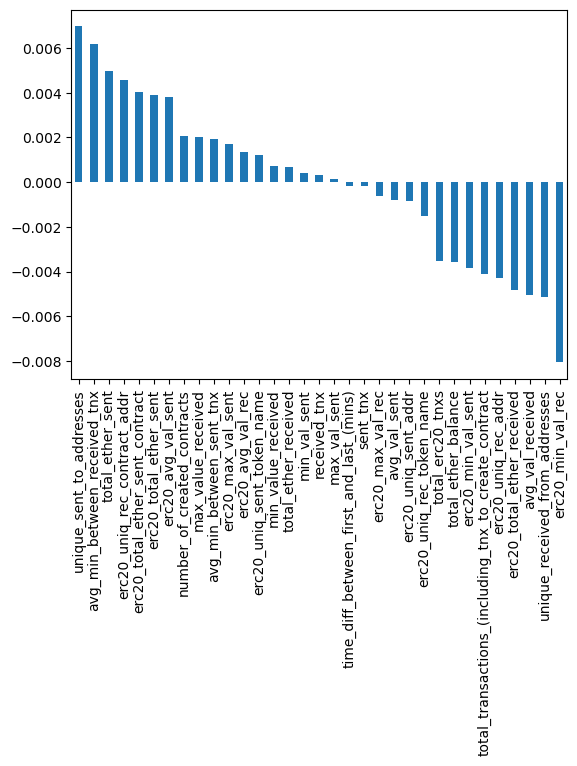

In [20]:
camo_mean.sort_values(ascending=False).plot.bar()